In [399]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

import gymnasium as gym
import numpy as np
import time

from IPython import display
import imageio
import os
FP = './animations'
# !pipreqsnb --force

In [400]:
from aux_func import *

In [512]:
class CartPoleDiscretized:
    """overrides most of that *** **** ****, 
        NB! not everything"""
    from types import SimpleNamespace
    from functools import wraps
    
    def discrete(method):
        """overwrites method's output state (considered to be the first element output in returned tuple)"""
        def inner(*args, **kwargs):
            results = method(*args, **kwargs)
            return list([args[0].encode(results[0]), *results[1:]])
        return inner
    
    def __init__(self, aid_to_str=ACTIONS_STR, discr_cfg=(10, 10, 10, 10), inf_cap=2.5):
        self.e = gym.make("CartPole-v1", render_mode="rgb_array")
        self.aid_to_str = ACTIONS_STR = ('<','>') # for policy visualization
        
        # i do hate gym environment interface for this particular thing
        self.action_space = SimpleNamespace(n=self.e.action_space.n)
        self.unwrapped = SimpleNamespace(spec=SimpleNamespace(id='CartPoleDiscretized-v1'))
        self.n_states = np.prod(discr_cfg)
        self.n_actions = self.action_space.n
        self.observation_space = SimpleNamespace(n=self.n_states)
        
        self.sd = self.e.observation_space.shape[0]
        self.ul = self.e.observation_space.high
        self.ll = self.e.observation_space.low
        if inf_cap:
            self.ul[1] = self.ul[3] = inf_cap
            self.ll[1] = self.ll[3] = -inf_cap
            
        self.b_eds, self.b_dims = self.get_bins(discr_cfg)

    def __repr__(self):
        return f"Discretized {self.e.unwrapped.spec.id} environment with {self.b_dims}={self.observation_space.n} states and {self.action_space.n} actions {self.aid_to_str}, named as {self.unwrapped.spec.id}"
        
    def get_bins(self, config):
        """handles list/tuple of both bin sizes or an array with exact bin values (accounted for -1)"""
        bin_edges, bin_sizes = [], []
        for i, b in enumerate(config):
            if isinstance(b, (int, np.integer)):
                bin_sizes.append(b)
                bin_edges.append(np.linspace(self.ll[i]/2, self.ul[i]/2, num=b-1)) # has to be 1 less cause we have n_edges=n_bins+1
            else:
                bin_sizes.append(len(b))
                bin_edges.append(b)
        return bin_edges, bin_sizes
        
    def discretize(self, observation):
        """multidimensional discretization of 4-tuple of floats, s.that each bin is defined by its edge, i.e. is a half-open interval [b_va[i-1], b_va[i])"""
        return list(np.digitize(o, b) for o, b in zip(observation, self.b_eds))

    def encode(self, observation):
        """represents 4-tuple of discretized observation as a single integer"""
        return np.ravel_multi_index(self.discretize(observation), dims=self.b_dims).item()
        
    @discrete
    def reset(self):
        return self.e.reset()
        
    @discrete
    def step(self, action):
        return self.e.step(action)

In [513]:
ENV = CartPoleDiscretized(discr_cfg=(20, 10, 10, 20), inf_cap=2.5)
ENV.ll

array([-4.8       , -2.5       , -0.41887903, -2.5       ], dtype=float32)

In [514]:
class ModelFreeAgent(RandAgent):
    """Model-free agent == R, TP functions of ENV aren't provided and aren't (explicitly?) approximated"""
    def __init__(self, env, aid_to_str):
        super().__init__(env=env, aid_to_str=aid_to_str)
        self.stc = 0 # counts improvement steps 

    def gpi(self, q, eps, zero_mask=None):
        """epsilon-greedy policy improvement based on values of q(s,a), at each state,
        policy ~ not only take an action that maximizes given action-value function q, 
        but also allow "the rest' actions happen with eps probability (shared)
        
        unvisited states have q=0 but that doesn't matter anything, 
        as rewards are < 0, such states would impact argmax in vain,
        zero_mask removes them from computation"""
        if zero_mask is not None:
            q[zero_mask] = np.full(shape=q.shape, fill_value=-10)[zero_mask]
            # q = np.ma.array(q, mask=zero_mask)
        # epsilon-greedy: let eps be ~"the rest' actions probability, split it between the all actions
        dummy = (1 - eps + eps / self.n_actions) * np.eye(self.n_actions) + (eps / self.n_actions) * (np.ones(self.n_actions) - np.eye(self.n_actions))
        best_actions = np.argmax(q, axis=0) # 1D array of 'best' actions
        # one-hot encoding of best_actions array (used to choose rows from dummy)
        self.policy = dummy[best_actions]
        self.stc += 1

    def fit(self, n_trajectories, max_length, alpha_d=0.5, gamma=0.99, eps_d=None, verbose=False):
        dh = display.display(display_id=True)
        eps_rates, alpha_rates = [], []
        if callable(alpha_d):
            alpha_d.n_total = n_trajectories
        if eps_d is not None:
            eps_d.n_total = n_trajectories
        else:
            eps_d = LinearAR(n_iterations=n_trajectories, start=1)
        for i, t in enumerate(range(n_trajectories)):
            # decrease eps throughout the loop
            eps = eps_d(i)
            # decrease alpha ~ learning rate
            alpha = alpha_d(i) if callable(alpha_d) else alpha_d
            # policy evaluation and improvement throughout trajectory
            results = self.walk(max_length=max_length, alpha=alpha, eps=eps, gamma=gamma)
            # visualization
            eps_rates.append(eps)
            alpha_rates.append(alpha)
            self.log.append(sum(results['r']))
            if verbose:
                # ax = self.show_policy()
                ax = self.learning_curve(title=f"Total reward at trajectory of length < {max_length}", l_scale=False)
                ax2 = ax.twinx()
                ax2.tick_params(axis='y', labelcolor='blueviolet')
                ax2 = sns.lineplot(eps_rates, linewidth=0.5, ax=ax2, label="exploration, ε‎", color='blueviolet')
                sns.lineplot(alpha_rates, linewidth=0.5, ax=ax2, label="learning rate, α", color='orchid')
                dh.update(plt.gcf())
                plt.close() # because plt.clf() is spurious

class SARSAAgent(ModelFreeAgent):
    """SARSA updates at each step of every trajectory"""
    def __init__(self, env, aid_to_str):
        super().__init__(env=env, aid_to_str=aid_to_str)
        self.Q = np.zeros_like(self.policy.T)
        self.fly = self.sarsa_step

    def sarsa_step(self, queue_6, alpha, eps, gamma):
        """accepts a queue object, updates value-function q and policy in sarsa manner"""
        if len(queue_6) == 6: # sarsar
            s, a, r, sx, ax = list(queue_6)[:5]
            self.Q[a, s] += alpha * (r + gamma * self.Q[ax, sx] - self.Q[a, s])
            self.gpi(self.Q, eps)

class QLearningAgent(ModelFreeAgent):
    """Q updates at each step of every trajectory"""
    def __init__(self, env, aid_to_str):
        super().__init__(env=env, aid_to_str=aid_to_str)
        self.Q = np.zeros_like(self.policy.T)
        self.fly = self.ql_step

    def ql_step(self, queue_6, alpha, eps, gamma):
        """accepts a queue object, updates value-function q and policy ~ Q-learning"""
        if len(queue_6) == 6: # sarsar
            s, a, r, sx = list(queue_6)[:4]
            self.Q[a, s] += alpha * (r + gamma * np.max(self.Q[:, sx]) - self.Q[a, s])
            self.gpi(self.Q, eps)

class MonteCarloAgent(ModelFreeAgent):
    """Applies Monte-Carlo sampling of trajectories for action-value function q approximation"""
    def __init__(self, env, aid_to_str):
        super().__init__(env=env, aid_to_str=aid_to_str)
    
    def walk_r(self, gamma, max_length):
        """transforms standard results after tracing a route, yields
            n (matrix a,s of visited state counts), 
            g (matrix a,s of returns)"""
        g, n = np.zeros_like(self.policy.T), np.zeros_like(self.policy.T)
        trajectory = super().walk(max_length=max_length)
        R, A, S = trajectory['r'], trajectory['a'], trajectory['s']
        # get rewards serie (summands, w/ discounting)
        gamma_ = np.cumprod(np.concatenate((np.atleast_1d(1.), np.tile(np.array(gamma), len(R) - 1))))
        R_discounted = gamma_ * np.array(R)
        # get values of returns G, e.g. total reward as if we'd started at timestep t and continued MDP on this trajectory
        G = np.array([np.sum(R_discounted[t:]) / gamma**t for t in range(len(R_discounted))])
        # get unique pairs from 2D array, their places and counts
        unp, pos, cts = np.unique(np.vstack([A, S]), axis=1, return_inverse=True, return_counts=True)
        # row vector of stacked Gt values @ matrix with (stacked as rows ~ pos) one-hot encoded unique states => row vector with sum of Gts at unique states
        g[*unp], n[*unp] = G @ (np.eye(len(cts))[pos]), cts
        return g, n, sum(R)

    def fit(self, n_trajectories, max_length, eps_d=None, gamma=1, verbose=False):
        """MC approach replaces expected value calculation with an empirical mean of return Gt"""
        dh = display.display(display_id=True)
        if eps_d is not None:
            eps_d.n_total = n_trajectories
        else:
            eps_d = LinearAR(n_iterations=n_trajectories, start=1)      
        eps_rates = []
        # np.full(shape=self.policy.T.shape, fill_value=-np.inf)
        G, N = np.zeros_like(self.policy.T), np.zeros_like(self.policy.T)
        for i, t in enumerate(range(n_trajectories)):
            # MC policy evaluation to approximate Q
            g, n, r = self.walk_r(max_length=max_length, gamma=gamma)
            G, N = G + g, N + n
            Q = G / (N_ := N.copy() + 1E-2 * (N == 0)) # prevent zero-division error
            
            # decrease eps throughout the loop
            eps = eps_d(i)
            
            # policy improvement (non-visited sa pairs are treated different)
            self.gpi(Q, eps=eps, zero_mask=N==0)

            # visualization
            self.log.append(r)
            eps_rates.append(eps)
            if verbose:
                # ax = self.show_policy()
                ax = self.learning_curve(title=f"Total reward at trajectory of length < {max_length}", l_scale=False)
                ax2 = ax.twinx()
                ax2.tick_params(axis='y', labelcolor='blueviolet')
                sns.lineplot(eps_rates, linewidth=0.5, ax=ax2, label="exploration, ε", color='blueviolet')
                dh.update(plt.gcf())
                plt.close() # because plt.clf() is spurious

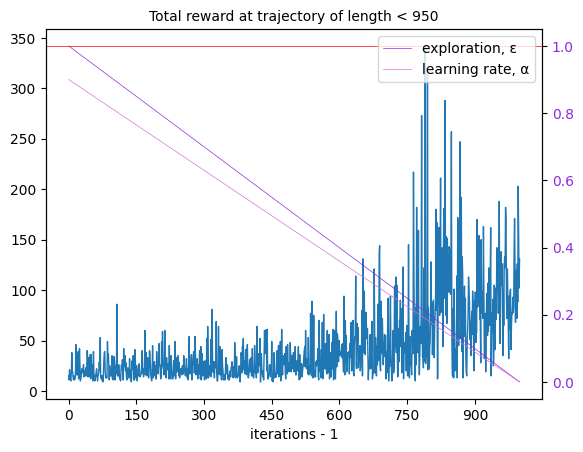

In [515]:
sarsa = SARSAAgent(env=ENV, aid_to_str=ENV.aid_to_str)
ann_sarsa_a = LinearAR(start=0.9)
ann_sarsa_e = None
# ann_sarsa_e = ExponentialAR(la=1e-2)
sarsa.fit(n_trajectories=1000, max_length=950, alpha_d=ann_sarsa_a, eps_d=ann_sarsa_e, gamma=0.999, verbose=True)